Article from Philippe:
https://practicalcheminformatics.blogspot.com/2023/06/getting-real-with-molecular-property.html


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import pandas as pd
from deepchem.feat import RDKitDescriptors
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
c:\Users\nina\anaconda3\envs\ai_chem\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (c:\Users\nina\anaconda3\envs\ai_chem\Lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loa

In [3]:
#combined data
#Merged_2 has curated, biogen and esol data. merged_solubility also has one other
data = pd.read_csv("../Data/Merged_solubility.csv")
print(data.columns)

Index(['SMILES', 'Solubility_log(mol/L)', 'Solubility(mol/L)', 'MolW(Da)',
       'NumHAcceptors', 'NumHDonors', 'LogP', 'Lipinski_rule'],
      dtype='object')


In [4]:
#disable warnings from RDKit
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*') 

### Data preparation

In [5]:
def canonicalize(Dataframe: pd.DataFrame):
    
    """Canonicalizes the SMILES from Dataframe. A column called 'SMILES' is requiered

    Args: Dataframe with 'SMILES' column contaning smiles. 
    """
    
    Dataframe['SMILES'] = Dataframe['SMILES'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x))) #canonicalize smiles from a Dataframe                                          
    

In [6]:
canonicalize(data)
data = data.drop_duplicates(subset="SMILES", keep='first') #prioritizes curated, biogen, then esol and then pharmaceutical database

In [7]:

# Function to generate features from SMILES strings using RDKit descriptors
def generate_features(smiles_list):
    featurizer = RDKitDescriptors()
    features = featurizer.featurize(smiles_list)
    # Drop features containing invalid values
    used_features = ~np.isnan(features).any(axis=0)
    features = features[:, ~np.isnan(features).any(axis=0)]
    return features, used_features

#remove nan values from data
data = data.dropna(subset=['Solubility_log(mol/L)'])

#get x and y data (x is the molecular descriptors, y is the solubility)
y_data = data["Solubility_log(mol/L)"]

print(len(y_data))

# Generate features from SMILES data (get smiles from df)
smiles = data["SMILES"]
X_data, used_features = generate_features(smiles)

#split data into training and validation using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
# Convert y pandas Series to NumPy array
y_train = y_train.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)

#scale x values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#convert data to pytorch tensors (like numpy arrays but for pytorch)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Reshape the target tensor to match the shape of the output tensor
y_train_tensor = y_train_tensor.view(-1, 1)
# Reshape the target tensor to match the shape of the output tensor
y_test_tensor = y_test_tensor.view(-1, 1)


12309


In [232]:
X_data.shape[1]

198

In [233]:
np.std(y_data)

2.237340946572077

### Grid search

activation function:
https://encord.com/blog/activation-functions-neural-networks/

In [234]:
#### CREATING MODEL ####

# Define the neural network architecture
class SolubilityPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SolubilityPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define hyperparameters
input_dim = X_data.shape[1]  # Number of molecular descriptors
hidden_dim = 256 #gets overruled by grid search
output_dim = 1
learning_rate = 0.001 #gets overruled by the grid search
num_epochs = 600
batch_size = 32

#create dataloader for batch training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#initialize model, loss function (nn.MSELoss) and optimizer
model = SolubilityPredictor(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

##### Grid-search for best hyperparameters #####
# Define your hyperparameter grid
param_grid = {
    'hidden_layer_sizes': [(512,512),(256,256,256),(512,512,512)],  # Number of neurons in the hidden layer(s)
    'activation': ['relu', 'tanh','logistic'],  # Activation function. logistic is same as sigmoid
    #'solver': ['adam', 'sgd'],  # Optimization algorithm
    #'learning_rate': ['constant', 'adaptive'],  # Learning rate schedule
    'learning_rate_init':[0.01,0.001,0.0001]
}

# Create an MLPRegressor object
mlp = MLPRegressor(max_iter=num_epochs, batch_size=batch_size)

# Perform grid search
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
model = grid_search.best_estimator_

# Evaluate the best model on the test set
test_score = model.score(X_test, y_test)
print("Test Score (R^2):", test_score)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END activation=relu, hidden_layer_sizes=(512, 512), learning_rate_init=0.01; total time= 4.5min
[CV] END activation=relu, hidden_layer_sizes=(512, 512), learning_rate_init=0.01; total time= 5.4min
[CV] END activation=relu, hidden_layer_sizes=(512, 512), learning_rate_init=0.01; total time= 3.5min
[CV] END activation=relu, hidden_layer_sizes=(512, 512), learning_rate_init=0.01; total time= 4.2min
[CV] END activation=relu, hidden_layer_sizes=(512, 512), learning_rate_init=0.01; total time= 1.9min
[CV] END activation=relu, hidden_layer_sizes=(512, 512), learning_rate_init=0.001; total time= 6.8min
[CV] END activation=relu, hidden_layer_sizes=(512, 512), learning_rate_init=0.001; total time=10.4min
[CV] END activation=relu, hidden_layer_sizes=(512, 512), learning_rate_init=0.001; total time= 7.5min
[CV] END activation=relu, hidden_layer_sizes=(512, 512), learning_rate_init=0.001; total time=29.6min
[CV] END activation=relu,

c:\Users\nina\anaconda3\envs\ai_chem\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(512, 512), learning_rate_init=0.0001; total time=36.9min
[CV] END activation=logistic, hidden_layer_sizes=(512, 512), learning_rate_init=0.0001; total time=29.3min


c:\Users\nina\anaconda3\envs\ai_chem\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(512, 512), learning_rate_init=0.0001; total time=37.0min
[CV] END activation=logistic, hidden_layer_sizes=(512, 512), learning_rate_init=0.0001; total time=35.1min
[CV] END activation=logistic, hidden_layer_sizes=(512, 512), learning_rate_init=0.0001; total time=33.0min
[CV] END activation=logistic, hidden_layer_sizes=(256, 256, 256), learning_rate_init=0.01; total time= 1.3min
[CV] END activation=logistic, hidden_layer_sizes=(256, 256, 256), learning_rate_init=0.01; total time=  59.9s
[CV] END activation=logistic, hidden_layer_sizes=(256, 256, 256), learning_rate_init=0.01; total time= 1.1min
[CV] END activation=logistic, hidden_layer_sizes=(256, 256, 256), learning_rate_init=0.01; total time= 1.2min
[CV] END activation=logistic, hidden_layer_sizes=(256, 256, 256), learning_rate_init=0.01; total time=  53.4s
[CV] END activation=logistic, hidden_layer_sizes=(256, 256, 256), learning_rate_init=0.001; total time= 3.5min
[CV] END activatio

In [235]:
# Evaluate the best model on the test set
test_predictions = model.predict(X_test)

# Calculate additional metrics
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

# Print the results
print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")
print(f"Test R^2: {test_r2}")


Test MSE: 1.0550654999961255
Test RMSE: 1.0271638136130603
Test MAE: 0.6723179912846099
Test R^2: 0.7920846939140014


In [237]:
import joblib

best_model = grid_search.best_estimator_
joblib.dump(best_model, 'best_mlp_model.pkl')


['best_mlp_model.pkl']

### Without grid search

In [156]:
#### CREATING MODEL ####

# Define the neural network architecture with multiple hidden layers
class SolubilityPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(SolubilityPredictor, self).__init__()
        layers = []
        previous_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(previous_dim, hidden_dim))
            layers.append(nn.Tanh())
            previous_dim = hidden_dim
        layers.append(nn.Linear(previous_dim, output_dim))
        self.network = nn.Sequential(*layers) 
        self.activation = nn.Tanh() #best according to grid search

    def forward(self, x):
        return self.network(x)

# Define hyperparameters
input_dim = X_data.shape[1]  # Number of molecular descriptors
hidden_dim = [512,512,512]  # (512,512,512) Best according to grid search
output_dim = 1
learning_rate = 0.001
num_epochs = 800
batch_size = 32

# Create DataLoader for batch training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss function (nn.MSELoss) and optimizer
model = SolubilityPredictor(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss}")

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
test_score = r2_score(y_test, y_pred)
print("Test Score (R^2):", test_score)


Epoch 1/800, Loss: 737.8418161571026
Epoch 2/800, Loss: 430.92745900154114
Epoch 3/800, Loss: 383.20267313718796
Epoch 4/800, Loss: 342.50970643758774
Epoch 5/800, Loss: 339.3627875447273
Epoch 6/800, Loss: 304.23266220092773
Epoch 7/800, Loss: 281.53028905391693
Epoch 8/800, Loss: 267.02549183368683
Epoch 9/800, Loss: 241.57228228449821
Epoch 10/800, Loss: 235.14435601234436
Epoch 11/800, Loss: 222.03872872889042
Epoch 12/800, Loss: 213.52282650768757
Epoch 13/800, Loss: 198.0638274475932
Epoch 14/800, Loss: 182.05337834358215
Epoch 15/800, Loss: 179.3672907203436
Epoch 16/800, Loss: 166.13004910945892
Epoch 17/800, Loss: 162.54093024134636
Epoch 18/800, Loss: 145.5851913690567
Epoch 19/800, Loss: 140.91619138419628
Epoch 20/800, Loss: 140.74349889159203
Epoch 21/800, Loss: 126.72975526750088
Epoch 22/800, Loss: 123.09767834842205
Epoch 23/800, Loss: 118.020671620965
Epoch 24/800, Loss: 110.8193983733654
Epoch 25/800, Loss: 107.43464197963476
Epoch 26/800, Loss: 101.87012980878353
Epo

In [157]:
model.eval() # Set the model to evaluation mode

# Perform the forward pass to get predictions
with torch.no_grad():
    test_predictions_tensor = model(X_test_tensor)

# Convert predictions back to NumPy array
test_predictions = test_predictions_tensor.numpy().flatten()

# Calculate additional metrics
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

# Print the results
print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")
print(f"Test R^2: {test_r2}")

Test MSE: 0.9972437620162964
Test RMSE: 0.9986209273338318
Test MAE: 0.659709632396698
Test R^2: 0.8053126728041079


### With dropout, weight decay
try dropout rates between 0.2 and 0.5.

In [54]:
# Define the neural network architecture with multiple hidden layers and dropout
class SolubilityPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(SolubilityPredictor, self).__init__()
        layers = []
        previous_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(previous_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))  # Adding dropout
            previous_dim = hidden_dim
        layers.append(nn.Linear(previous_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Define hyperparameters
input_dim = X_data.shape[1]  # Number of molecular descriptors
hidden_dims = [512, 512, 512]  # Best according to grid search
output_dim = 1
learning_rate = 0.001
num_epochs = 1000
batch_size = 32

# Create DataLoader for batch training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss function (nn.MSELoss) and optimizer with weight decay (L2 regularization)
model = SolubilityPredictor(input_dim, hidden_dims, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if epoch % 100 == 0:  # Print loss every 100 epochs
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss}")

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy().flatten()

test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")
print(f"Test R^2: {test_r2}")


Epoch 1/1000, Loss: 681.7832328081131
Epoch 101/1000, Loss: 111.76737007498741
Epoch 201/1000, Loss: 74.74509523808956
Epoch 301/1000, Loss: 64.90365134179592
Epoch 401/1000, Loss: 56.54144813865423
Epoch 501/1000, Loss: 55.897232234478
Epoch 601/1000, Loss: 51.54749147221446
Epoch 701/1000, Loss: 52.32152093201876
Epoch 801/1000, Loss: 46.192381370812654
Epoch 901/1000, Loss: 48.13287205994129
Test MSE: 1.2193962335586548
Test RMSE: 1.1042627096176147
Test MAE: 0.695110559463501
Test R^2: 0.7752118032844304


### Saving the best model

In [158]:
torch.save(model.state_dict(), 'solubility_model.pth')


## Transfer learning

Try to make it classification instead of regression? No, just calculate how correct it is with a cut-off of 0.5 after predictions. 
can choose to say the values between 0.4 and 0.6 are inconclusive

Also, use logK(%F) as it has a more balanced distribution

See "Critical Evaluation of Human Oral Bioavailability for Pharmaceutical Drugs by Using Various Cheminformatics Approaches"

In [74]:
data = pd.read_csv("../Data/Merged_Bioavailibility.csv")

In [75]:

#### DATA PREPARATION ####
# try with new data

#remove nan values from data
data = data.dropna(subset=['logK(%F)'])

#get x and y data (x is the molecular descriptors, y is the solubility)
y_data = data["logK(%F)"]

print(len(y_data))

#generating features and making sure it's the same features as previous model
smiles = data["SMILES"]
featurizer = RDKitDescriptors()
features = featurizer.featurize(smiles)
X_data = features[:,used_features]


1587


In [76]:

print(X_data.shape[1])
if True in np.isnan(X_data):
    print("yes")

198


In [77]:
np.std(y_data)

1.2739898996323888

In [78]:
# Split data into training and validation using train_test_split while retaining indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X_data, y_data, data.index, test_size=0.2, random_state=42)
# Convert y pandas Series to NumPy array
y_train = y_train.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)

#scale x values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#convert data to pytorch tensors (like numpy arrays but for pytorch)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Reshape the target tensor to match the shape of the output tensor
y_train_tensor = y_train_tensor.view(-1, 1)
# Reshape the target tensor to match the shape of the output tensor
y_test_tensor = y_test_tensor.view(-1, 1)


In [92]:
#define model again

# Define the neural network architecture with multiple hidden layers
class SolubilityPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(SolubilityPredictor, self).__init__()
        layers = []
        previous_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(previous_dim, hidden_dim))
            layers.append(nn.Tanh())
            previous_dim = hidden_dim
        layers.append(nn.Linear(previous_dim, output_dim))
        self.network = nn.Sequential(*layers)
        self.activation = nn.Tanh() #best according to grid search

    def forward(self, x):
        return self.network(x)

# Define hyperparameters
input_dim = X_data.shape[1]  # Number of molecular descriptors
hidden_dim = [512,512,512]  # (512,512,512) Best according to grid search
output_dim = 1
learning_rate = 0.001
num_epochs = 1000
batch_size = 32

#loading saved model
model = SolubilityPredictor(input_dim, hidden_dim, output_dim)
model.load_state_dict(torch.load('solubility_model.pth'))

# Optionally, modify the final layer if the output dimension is different

<All keys matched successfully>

In [93]:
class BioavailabilityPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(BioavailabilityPredictor, self).__init__()
        self.base_model = SolubilityPredictor(input_dim, hidden_dims, output_dim)
        
        # New layers for bioavailability prediction
        self.new_layers = nn.Sequential(
            nn.Linear(output_dim, 256),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )
    
    def forward(self, x):
        x = self.base_model(x)
        x = self.new_layers(x)
        return x

# Create the new model
bioavailability_model = BioavailabilityPredictor(input_dim, hidden_dim, output_dim)
bioavailability_model.base_model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [94]:
#initially freeze the pre-trained layers
for param in bioavailability_model.base_model.parameters():
    param.requires_grad = False


In [95]:
# train only the new layers added for the task:

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(bioavailability_model.new_layers.parameters(), lr=learning_rate)

#setting a smaller batch size for fine-tuning:
batch_size = 16

#create dataloader for batch training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Set the model to training mode
bioavailability_model.train()

num_epochs = 500

# Training loop for new layers
for epoch in range(num_epochs):
    bioavailability_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = bioavailability_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    if epoch % 100 == 0:  # Print loss every 100 epochs
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss}")


Epoch 1/500, Loss: 139.46553444862366
Epoch 101/500, Loss: 135.1947499215603
Epoch 201/500, Loss: 135.11916008591652
Epoch 301/500, Loss: 132.65568074584007
Epoch 401/500, Loss: 132.32993498444557


In [96]:
#fine-tune it by unfreezing some of the pre-trained layers

# Unfreeze some of the pre-trained layers
for param in bioavailability_model.base_model.network[-4].parameters():  # Unfreeze the second last layer
    param.requires_grad = True
for param in bioavailability_model.base_model.network[-7].parameters():  # Unfreeze the third last layer (optional)
    param.requires_grad = True

# Update the optimizer to include the parameters of the unfrozen layers
optimizer = optim.Adam(bioavailability_model.parameters(), lr=learning_rate / 10)

#maybe more epochs?
num_epochs = 4000

# Fine-tuning loop
for epoch in range(num_epochs):
    bioavailability_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = bioavailability_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    if epoch % 100 == 0:  # Print loss every 100 epochs
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss}")


Epoch 1/4000, Loss: 132.27835100889206
Epoch 101/4000, Loss: 96.57175113260746
Epoch 201/4000, Loss: 80.25051034241915
Epoch 301/4000, Loss: 66.69406558573246
Epoch 401/4000, Loss: 59.995260149240494
Epoch 501/4000, Loss: 49.507852237671614
Epoch 601/4000, Loss: 42.34172458574176
Epoch 701/4000, Loss: 34.174675799906254
Epoch 801/4000, Loss: 29.44404430873692
Epoch 901/4000, Loss: 25.142369478708133
Epoch 1001/4000, Loss: 21.815903378650546
Epoch 1101/4000, Loss: 19.06011823983863
Epoch 1201/4000, Loss: 16.48091491078958
Epoch 1301/4000, Loss: 14.515323223546147
Epoch 1401/4000, Loss: 13.718736708629876
Epoch 1501/4000, Loss: 10.543535957112908
Epoch 1601/4000, Loss: 8.771212974213995
Epoch 1701/4000, Loss: 7.895337809924968
Epoch 1801/4000, Loss: 7.160496835713275
Epoch 1901/4000, Loss: 6.5896025251131505
Epoch 2001/4000, Loss: 5.727444467833266
Epoch 2101/4000, Loss: 6.027607025345787
Epoch 2201/4000, Loss: 5.021162707125768
Epoch 2301/4000, Loss: 4.628999706124887
Epoch 2401/4000, L

In [97]:
bioavailability_model.eval() # Set the model to evaluation mode

# Perform the forward pass to get predictions
with torch.no_grad():
    test_predictions_tensor = bioavailability_model(X_test_tensor)

# Convert predictions back to NumPy array
test_predictions = test_predictions_tensor.numpy().flatten()

# Calculate additional metrics
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

# Print the results
print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")
print(f"Test R^2: {test_r2}")

Test MSE: 3.240316867828369
Test RMSE: 1.8000880479812622
Test MAE: 1.3673293590545654
Test R^2: -1.1959190894102032


In [98]:
# Create a new DataFrame to store the results
results_df = data.loc[test_indices, ["logK(%F)"]].copy()

# Add the test predictions to the DataFrame
results_df["Test Prediction"] = test_predictions


In [99]:
results_df = results_df.reset_index(drop=True)

# count correct predictions
count_total = len(results_df["logK(%F)"])

count_correct = 0
for i in range(count_total):
    if results_df["Test Prediction"][i] > 0.5 and results_df["logK(%F)"][i] > 0.5:
        count_correct += 1
    elif results_df["Test Prediction"][i] < 0.5 and results_df["logK(%F)"][i] < 0.5:
        count_correct += 1

print(count_correct/count_total)

0.6037735849056604


1) using sensitivity (percentage of high oral bioavailable drugs predict-
ed correctly), specificity (percentage of low oral bioavailable
drugs predicted correctly), and CCR (correct classification
rate or balanced accuracy) for CTG models; and 
2) Pearson’s multiple linear correlation coefficient (R2) and mean absolute
error (MAE) for CNT models

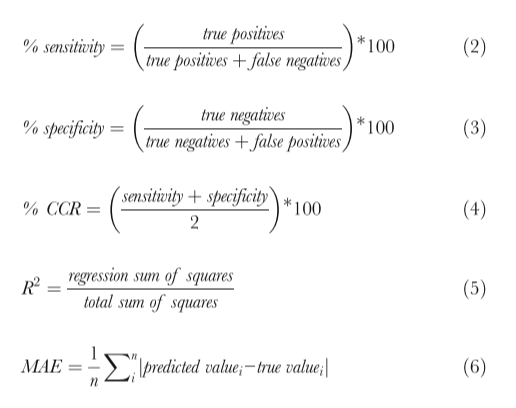

In [100]:
# calculate metrics
TP = ((results_df["Test Prediction"] > 0.5) & (results_df["logK(%F)"] > 0.5)).sum()
FN = ((results_df["Test Prediction"] < 0.5) & (results_df["logK(%F)"] > 0.5)).sum()
TN = ((results_df["Test Prediction"] < 0.5) & (results_df["logK(%F)"] < 0.5)).sum()
FP = ((results_df["Test Prediction"] > 0.5) & (results_df["logK(%F)"] < 0.5)).sum()

sensitivity = TP/(TP+FN)
print(f"Sensitivity: {sensitivity}")

specificity = TN/(TN+FP)
print(f"Specificity: {specificity}")

CCR = ((sensitivity+specificity)/2)*100
print(f"Correct classfication rate: {CCR}")


Sensitivity: 0.5192307692307693
Specificity: 0.6448598130841121
Correct classfication rate: 58.20452911574407


In [101]:
torch.save(bioavailability_model.state_dict(), 'bioavailability_model.pth')